## Подготовка данных

### Импорт пакетов и загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 86 kB/s 


In [36]:
#@title imports { form-width: "25%" }
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from category_encoders import TargetEncoder
import time
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import xgboost as xgb
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
warnings.filterwarnings('ignore')

2.9.2


Считаем таблицу и распечатаем ее.

In [16]:
ebw_data = pd.read_csv('/content/drive/MyDrive/datasets/ebw_data.csv')
ebw_data.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [8]:
ebw_data.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


### Очистка данных и восстановление пропусков

Выведем полный перечень столбцов

In [9]:
ebw_data.columns

Index(['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'], dtype='object')

**Пойдем по каждому признаку, где есть подозрительно низкие или высокие значения:**

* *** IW** 

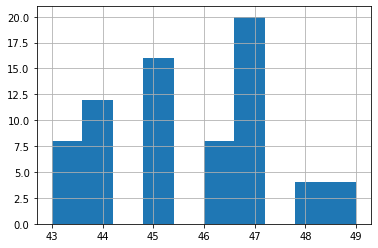

In [10]:
ebw_data['IW'].hist();

* *** IF** 

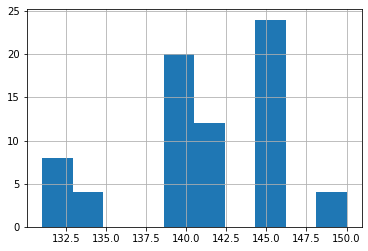

In [11]:
ebw_data['IF'].hist();

*** VW**

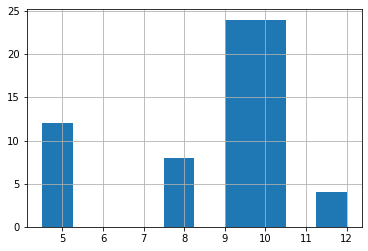

In [12]:
ebw_data['VW'].hist();

*** FP**

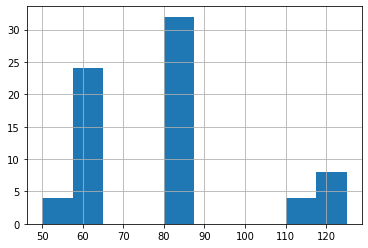

In [13]:
ebw_data['FP'].hist();

#### Восстановление / удаление пропусков в данных

In [15]:
ebw_data.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

#### Отбор и анализ признаков

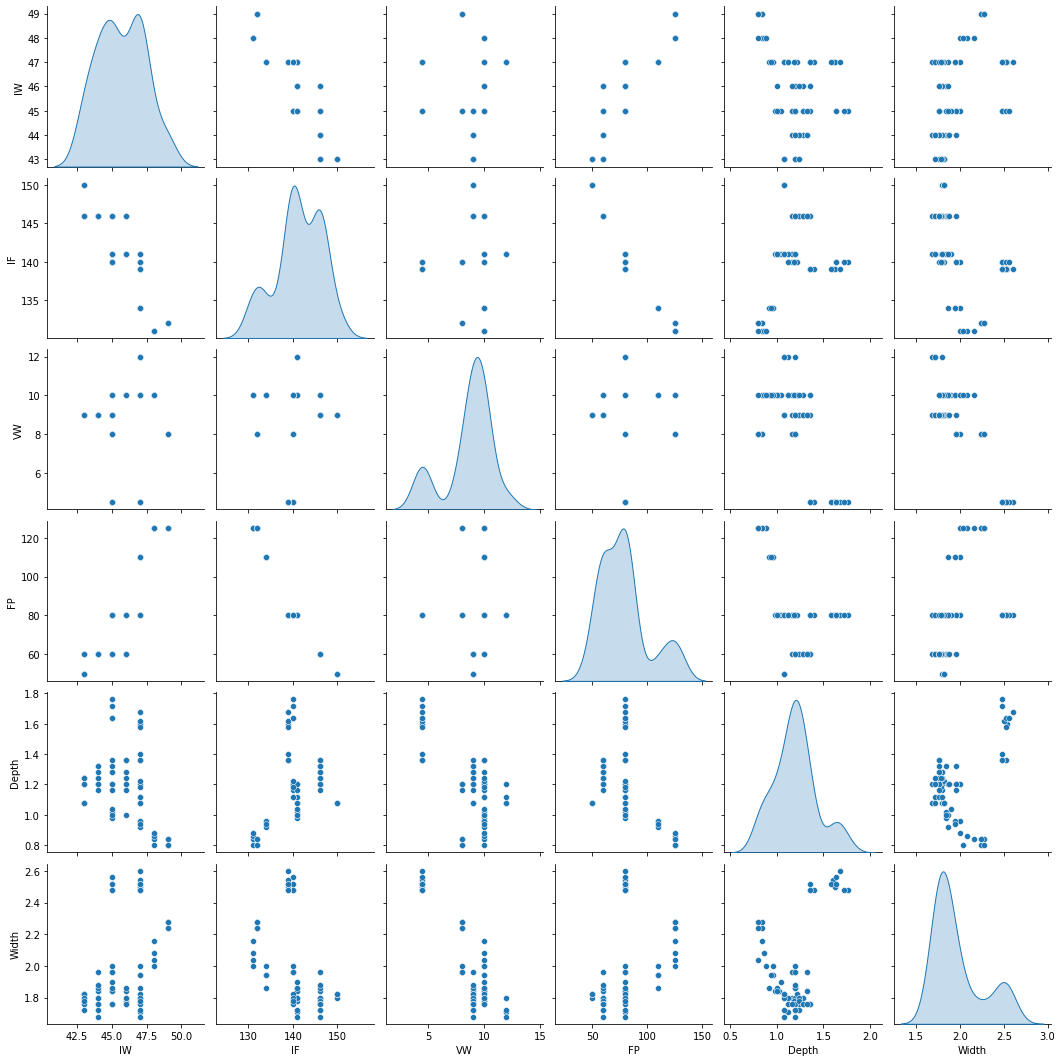

In [35]:
df = ebw_data.copy()
sns.pairplot(df[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']], diag_kind='kde');

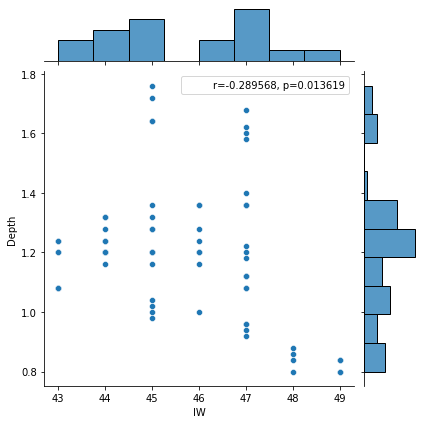

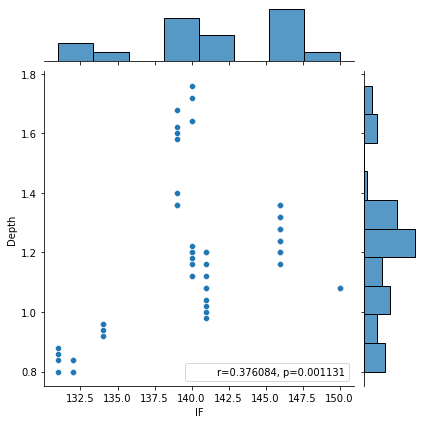

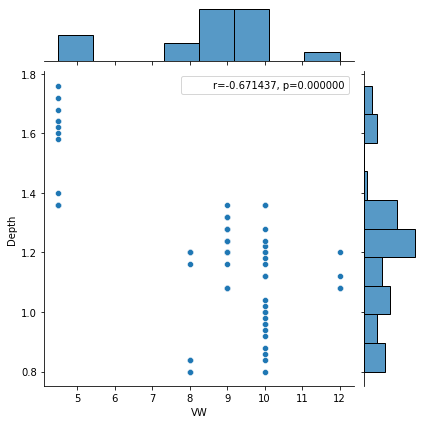

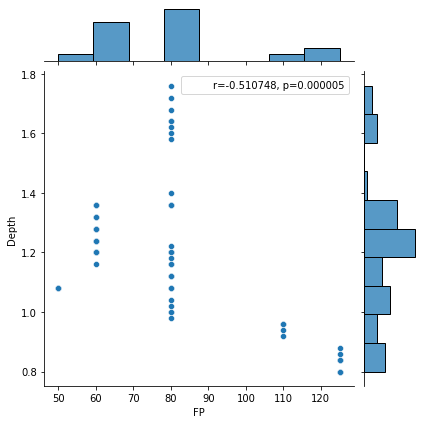

In [17]:
for i in ['IW', 'IF', 'VW', 'FP']:
  graph = sns.jointplot(data=df, x=i, y='Depth')
  r, p = stats.pearsonr(df[i], df['Depth'])
  phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
  graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

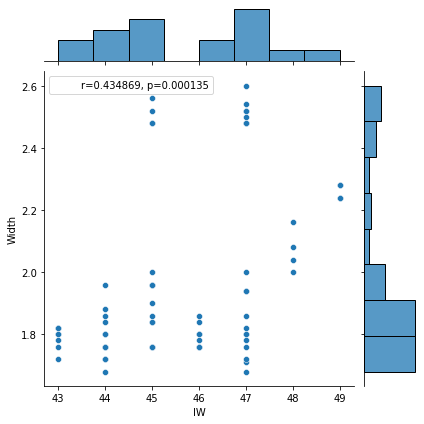

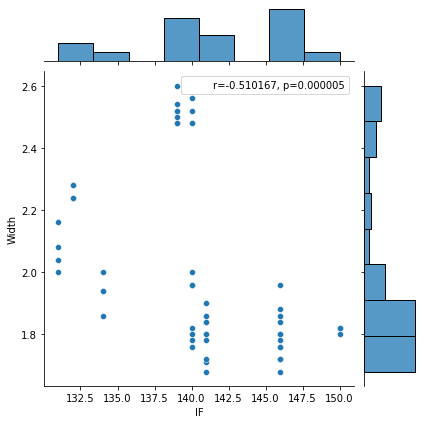

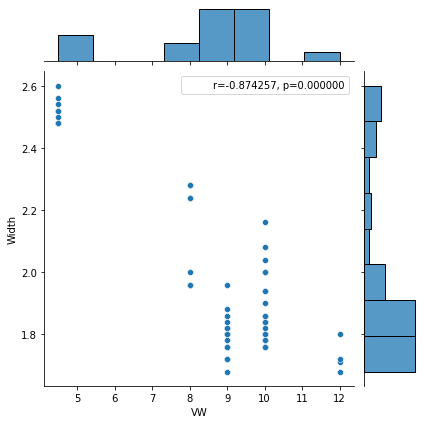

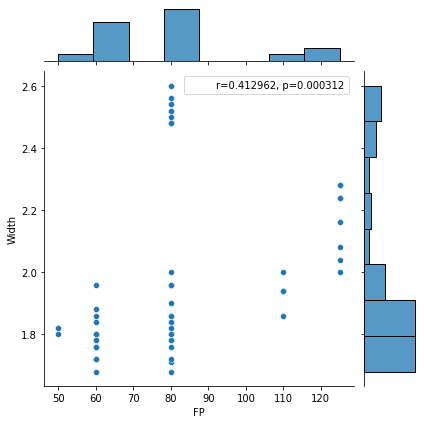

In [19]:
for i in ['IW', 'IF', 'VW', 'FP']:
  graph = sns.jointplot(data=df, x=i, y='Width')
  r, p = stats.pearsonr(df[i], df['Width'])
  phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
  graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

#### Оценка корреляции

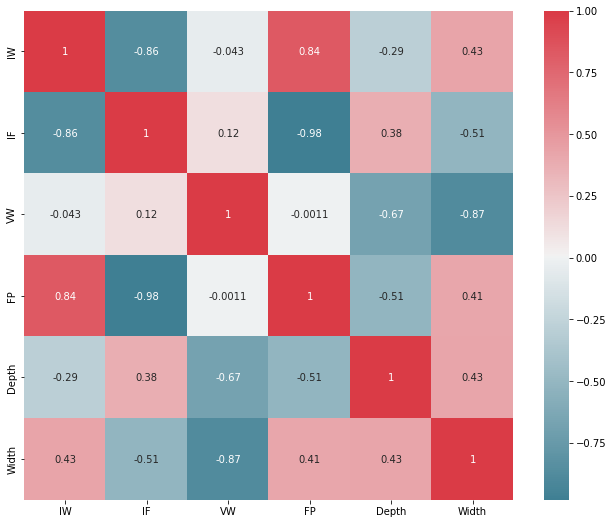

In [21]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),cmap=cmap,square=True,annot=True);

#### Стандартизация и разбивка датасета

In [25]:
x = df[['IW', 'IF', 'VW', 'FP']].to_numpy()
y = df[['Depth', 'Width']].to_numpy()
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train[:5]

array([[ 0.74265882, -0.04987216,  1.65415353,  0.04321141],
       [-0.99699403,  0.89769886,  0.06057464, -0.85244335],
       [-0.99699403,  0.89769886,  0.06057464, -0.85244335],
       [ 1.32254311, -1.94501419,  0.5917676 ,  2.05843464],
       [ 1.90242739, -1.75549998, -0.47061833,  2.05843464]])

## Обучение моделей

Начнем с простых моделей - линейной регрессии.

### Linear Regression

In [26]:
%%time

regressor = MultiOutputRegressor(LinearRegression())
print('Training for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

Training for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 0.08321751781865408
CPU times: user 33.8 ms, sys: 0 ns, total: 33.8 ms
Wall time: 109 ms


### Ridge Regression

In [30]:
%%time

regressor = MultiOutputRegressor(Ridge())
print('Training for root_mean_squared_error')
print()
cv_RMSE_Rg = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_Rg)

Training for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 0.09022827372132303
CPU times: user 27.7 ms, sys: 643 µs, total: 28.4 ms
Wall time: 32.2 ms


### CatBoostRegressor

In [31]:
%%time

regressor = MultiOutputRegressor(CatBoostRegressor()) 
print('Training for root_mean_squared_error')
print()
cv_RMSE_CBR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_CBR)

Выходные данные были обрезаны до нескольких последних строк (5000).
7:	learn: 0.2339879	total: 3.68ms	remaining: 457ms
8:	learn: 0.2302395	total: 4.23ms	remaining: 465ms
9:	learn: 0.2264980	total: 4.65ms	remaining: 460ms
10:	learn: 0.2231740	total: 5.09ms	remaining: 458ms
11:	learn: 0.2199676	total: 5.52ms	remaining: 455ms
12:	learn: 0.2165237	total: 5.97ms	remaining: 453ms
13:	learn: 0.2130382	total: 6.36ms	remaining: 448ms
14:	learn: 0.2102397	total: 6.86ms	remaining: 450ms
15:	learn: 0.2070418	total: 7.31ms	remaining: 449ms
16:	learn: 0.2042559	total: 7.72ms	remaining: 447ms
17:	learn: 0.2010758	total: 8.19ms	remaining: 447ms
18:	learn: 0.1979119	total: 8.61ms	remaining: 444ms
19:	learn: 0.1950849	total: 9.03ms	remaining: 442ms
20:	learn: 0.1920639	total: 9.47ms	remaining: 442ms
21:	learn: 0.1893804	total: 9.94ms	remaining: 442ms
22:	learn: 0.1869418	total: 10.4ms	remaining: 441ms
23:	learn: 0.1846228	total: 10.9ms	remaining: 441ms
24:	learn: 0.1821847	total: 11.3ms	remaining: 440ms

### DecisionTreeRegressor

In [32]:
%%time

regressor = MultiOutputRegressor(DecisionTreeRegressor()) 
print('Training for root_mean_squared_error')
print()
cv_RMSE_DTR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_DTR)

Training for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 0.06891736888550129
CPU times: user 28.3 ms, sys: 0 ns, total: 28.3 ms
Wall time: 36 ms


### LGBM

In [33]:
%%time

regressor = MultiOutputRegressor(LGBMRegressor()) 
print('Training for root_mean_squared_error')
print()
cv_RMSE_LGBMR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LGBMR)

Training for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 0.21333028284704586
CPU times: user 247 ms, sys: 3.63 ms, total: 251 ms
Wall time: 187 ms


### XGBoost

In [34]:
%%time
xgr =  MultiOutputRegressor(xgb.XGBRegressor())
print('Training for root_mean_squared_error')
print()
cv_RMSE_XGR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_XGR)

Training for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 0.21333028284704586
CPU times: user 176 ms, sys: 4.05 ms, total: 180 ms
Wall time: 104 ms


###Deep neural model

In [44]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(2)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [46]:
%%time
dnn_model = build_and_compile_model()
history = dnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    verbose=1, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 137ms/step - loss: 2.2699 - val_loss: 2.3207
Epoch 2/100
2/2 [==============================] - 0s 24ms/step - loss: 1.9023 - val_loss: 1.9618
Epoch 3/100
2/2 [==============================] - 0s 33ms/step - loss: 1.5560 - val_loss: 1.6177
Epoch 4/100
2/2 [==============================] - 0s 31ms/step - loss: 1.2346 - val_loss: 1.2861
Epoch 5/100
2/2 [==============================] - 0s 24ms/step - loss: 0.9374 - val_loss: 0.9825
Epoch 6/100
2/2 [==============================] - 0s 25ms/step - loss: 0.6828 - val_loss: 0.7244
Epoch 7/100
2/2 [==============================] - 0s 24ms/step - loss: 0.4882 - val_loss: 0.5276
Epoch 8/100
2/2 [==============================] - 0s 25ms/step - loss: 0.3499 - val_loss: 0.3972
Epoch 9/100
2/2 [==============================] - 0s 24ms/step - loss: 0.2853 - val_loss: 0.3258
Epoch 10/100
2/2 [==============================] - 0s 25ms/step - loss: 0.2453 - val_loss: 0.2956
Epoch 11/100
2/2 [

In [47]:
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                320       
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


In [48]:
dnn_model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 35ms/step - loss: 0.0077


0.007729846052825451

### Сравнение моделей

Самый низкий показатель ошибки получился у относительно неглубокой нейронной сети - ее и возьмем в качестве модели для нашего приложения.